### Adaptive Boosting
---
For Questions 12-18, implement the AdaBoost-Stump algorithm as introduced in Lecture 208. Run the algorithm on the following set for training: **`hw6_adaboost_train.dat`** and the following set for testing: **`hw6_adaboost_test.dat`.**

Use a total of $T = 300$ iterations (please do not stop earlier than 300), and calculate $E_{in}$ and $E_{out}$ with the 0/1 error. 

For the decision stump algorithm, please implement the following steps. Any ties can be arbitrarily broken.

(1) For any feature $i$, sort all the $x_{n,i}$ values to $x_{[n],i}$ such that $x_{[n],i} \le x_{[n+1],i}$.

(2) Consider thresholds within $−∞$ and all the midpoints $\frac{x_{[n],i} + x_{[n+1],i}}{2}$. Test those thresholds with $s \in \{−1, +1\}$ to determine the best $(s, \theta)$ combination that minimizes $E_{u}$ using feature $i$.

(3) Pick the best $(s, i, \theta)$ combination by enumerating over all possible $i$.

For those interested, step 2 can be carried out in $O(N)$ time only!!

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

def generate_data(file):
    """Return data point X and lable Y."""
    data = pd.read_csv(file, sep=' ', header=None)
    X = data.loc[:, 0:1]
    Y = np.array(data.loc[:, 2:]).flatten()
    
    return X, Y

##### Build multi-decision stump algorithm

In [2]:
def get_thresholds(X):
    """Return median as the thresholds given data of one dimenson."""
    X_sort = [max(X) + 1] + sorted(X)      # use max as the extreme case (classify all data to one side)
    thresholds = [(X_sort[i] + X_sort[i + 1]) / 2 for i in range(len(X) - 1)]
    
    return thresholds


def stump(X, params):
    col, theta, s = params
    return s * np.sign(X[col] - theta)


def multi_decision_stump(X, Y, W):
    """ Decision stump model for multi-dimensional data by minimizing weighted error. 
        Return theta (threshold), s and weighted classification error.
    """
    
    # initialize a large number for error
    min_err = Y.shape[0]
    
    # iterate over all columns
    for col in range(X.shape[1]):
        thresholds = get_thresholds(X[col])

        # iterate over all thresholds and compare weighted error
        for threshold in thresholds:
            for s in [1, -1]:
                theta = threshold
                Y_pred = stump(X, params=(col, theta, s))
                weighted_err = np.sum(W * (Y_pred != Y))
                
                if weighted_err < min_err:
                    best = theta, s, col, weighted_err
                    min_err = weighted_err
                    
    return best


##### Build AdaBoost stump algorithm

In [3]:
def AdaBoost_Stump(X, Y, T):
    
    # initialize weights
    weights = np.ones(X.shape[0]) / X.shape[0]
    
    alpha_list = []       # alpha of the hypothesis g for each iteration
    g_list = []           # parameters=(col, theta, s) of the hypothesis g for each iteration
    W_list = []           # list of weight vector per iteration (list of lists)
    e_list = []           # error rate of the hypothesis g for each iteration
    err_in_list = []      # weighted training error of the hypothesis g for each iteration

    for t in range(T):
        if t % 10 == 9:
            print(' Running the %d-th iteration' %(t+1))
        
        # Build decision stump model
        theta, s, col, weighted_err = multi_decision_stump(X_train, Y_train, weights) 
        
        # Compute resclaing factor
        e = weighted_err / np.sum(weights)
        rescale = np.sqrt((1 - e) / e)
        
        # Rescale the weight vector
        Y_pred = stump(X_train, params=(col, theta, s))
        mask = np.array(Y_pred == Y)
        weights[mask] /= rescale
        weights[~mask] *= rescale
                
        # Get alpha, g, U, e, err_in
        alpha_list.append(np.log(rescale))
        g = col, theta, s
        g_list.append(list(g))
        W_list.append(np.sum(weights))
        e_list.append(e)
        err_in_list.append(weighted_err)

    print('----------    END    ----------')
    
    return alpha_list, g_list, W_list, e_list, err_in_list


def test_model(X, Y, alpha, g, T):
    G = np.zeros(Y.shape[0])
    for t in range(T):
        params = list(g[t])
        G += alpha[t] * stump(X, params)
    
    Y_pred = np.sign(G)
    
    return np.sum(Y_pred != Y) / len(Y)       

##### Tranining model

In [4]:
train_file = 'data/hw6_adaboost_train.dat.txt'; test_file = 'data/hw6_adaboost_test.dat.txt'
X_train, Y_train = generate_data(train_file)
X_test, Y_test = generate_data(test_file)

In [5]:
T = 300

print('===== Starting Training =====')
start = time.clock()
alpha, g, W, e, err_in_g = AdaBoost_Stump(X_train, Y_train, T)

print('\nUsing %f seconds.\n' % (time.clock() - start))

train_err = test_model(X_train, Y_train, alpha, g, T)
train_acc = (1 - train_err) * 100
print('Model accuracy on the training set: %.2f %%' %train_acc)

test_err = test_model(X_test, Y_test, alpha, g, T)
test_acc = (1 - test_err) * 100
print('Model accuracy on the testing set: %.2f' %test_acc)

===== Starting Training =====
 Running the 10-th iteration
 Running the 20-th iteration
 Running the 30-th iteration
 Running the 40-th iteration
 Running the 50-th iteration
 Running the 60-th iteration
 Running the 70-th iteration
 Running the 80-th iteration
 Running the 90-th iteration
 Running the 100-th iteration
 Running the 110-th iteration
 Running the 120-th iteration
 Running the 130-th iteration
 Running the 140-th iteration
 Running the 150-th iteration
 Running the 160-th iteration
 Running the 170-th iteration
 Running the 180-th iteration
 Running the 190-th iteration
 Running the 200-th iteration
 Running the 210-th iteration
 Running the 220-th iteration
 Running the 230-th iteration
 Running the 240-th iteration
 Running the 250-th iteration
 Running the 260-th iteration
 Running the 270-th iteration
 Running the 280-th iteration
 Running the 290-th iteration
 Running the 300-th iteration
----------    END    ----------

Using 72.090969 seconds.

Model accuracy on th

#### 12. Plot a figure for $t$ versus $E_{in}(g_t)$. What is $E_{in}(g_1)$ and what is $\alpha_1$?

#### 13. From the figure in the previous question, should $E_{in}(g_t)$ be decreasing or increasing? Write down your observations and explanations.

Weighted error for the first iteration: 0.24
Alpha for the first iteration: 0.576340


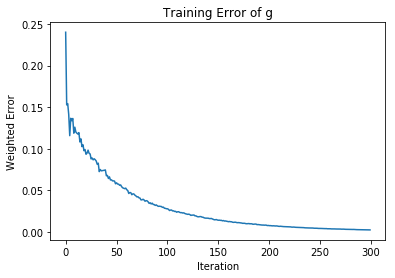

In [6]:
plt.plot(err_in_g)
plt.title('Training Error of g')
plt.xlabel('Iteration')
plt.ylabel('Weighted Error')

print('Weighted error for the first iteration: %.2f' %err_in_g[0])
print('Alpha for the first iteration: %f' %alpha[0])

#### Plot a figure for $t$ versus $E_{in}(G_t)$, where $G_{t}(x) = \sum^t_{T=1} \alpha_{T} g_{T} (x)$. That is, $G = G_{T}$. What is $E_{in}(G)$ ?

Computing Training Error of G
... 50-th iteration
... 100-th iteration
... 150-th iteration
... 200-th iteration
... 250-th iteration
... 300-th iteration

Training error for the last iteration: 0.00


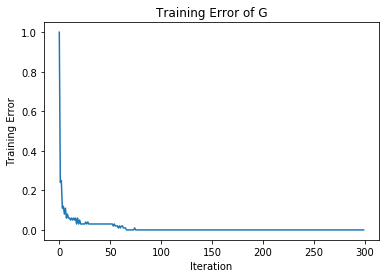

In [7]:
print('Computing Training Error of G')

err_in_G = []
for i in range(T):
    if i % 50 == 49:
        print('... %d-th iteration' %(i + 1))
    err_in_G.append(test_model(X_train, Y_train, alpha, g, i))
    

plt.plot(err_in_G)
plt.title('Training Error of G')
plt.xlabel('Iteration')
plt.ylabel('Training Error')

print('\nTraining error for the last iteration: %.2f' %err_in_G[-1])

#### 15. Plot a figure for $t$ versus $U_{t}$, where $U_t = \sum^N_{n=1} u^{(t)}_n$ . What is $U_2$ and what is $U_T$ ?

U_2: 0.654504
U_T: 0.005401


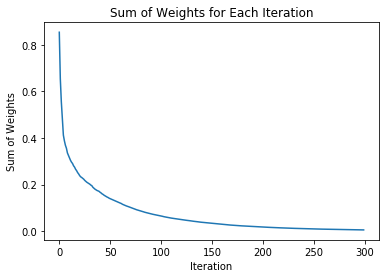

In [9]:
U = [np.sum(w) for w in W]

plt.plot(U)
plt.title('Sum of Weights for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Sum of Weights')

print('U_2: %f' %U[1]); print('U_T: %f' %U[-1])

#### 16. Plot a figure for $t$ versus $\epsilon_t$. What is the minimum value of $\epsilon_t$?

Minimum value of e: 0.178728


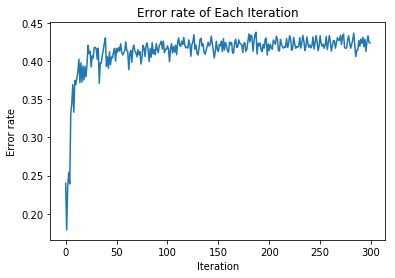

In [10]:
plt.plot(e)
plt.title('Error rate of Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error rate')

print('Minimum value of e: %f' %min(e))

#### 17. Plot a figure for $t$ versus $E_{out}(g_t)$ estimated with the test set. What is $E_{out}(g_1)$ ?

Computing Testing Error of g
... 50-th iteration
... 100-th iteration
... 150-th iteration
... 200-th iteration
... 250-th iteration
... 300-th iteration

Testing error of the first iteration: 0.25


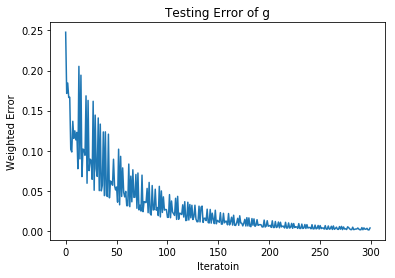

In [11]:
print('Computing Testing Error of g')

err_out_g = []
for i in range(T):
    if i % 50 == 49:
        print('... %d-th iteration' %(i + 1))
    
    params = list(g[i])
    Y_pred = stump(X_test, params)
    avg_weighted_err = np.sum(np.array(W[i]) * (Y_pred != Y_test)) / len(Y_test)
    err_out_g.append(avg_weighted_err)

plt.plot(err_out_g)
plt.title('Testing Error of g')
plt.xlabel('Iteratoin')
plt.ylabel('Weighted Error')

print('\nTesting error of the first iteration: %.2f' %err_out_g[0])

#### 18. Plot a figure for $t$ versus $E_{out}(G_t)$ estimated with the test set. What is $E_{out}(G)$ ?

Computing Testing Error of G
... 50-th iteration
... 100-th iteration
... 150-th iteration
... 200-th iteration
... 250-th iteration
... 300-th iteration

Testing error for the last iteration: 0.00


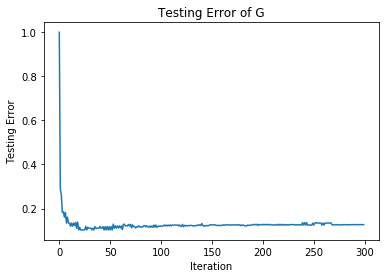

In [12]:
print('Computing Testing Error of G')

err_out_G = []
for i in range(T):
    if i % 50 == 49:
        print('... %d-th iteration' %(i + 1))
    err_out_G.append(test_model(X_test, Y_test, alpha, g, i))
    

plt.plot(err_out_G)
plt.title('Testing Error of G')
plt.xlabel('Iteration')
plt.ylabel('Testing Error')

print('\nTesting error for the last iteration: %.2f' %err_in_G[-1])

### Kernel Ridge Regression
---
Write a program to implement the kernel ridge regression algorithm from Lecture 206, and use it for classification (i.e. implement LSSVM). Consider the following data set **`hw6_lssvm_all.dat`**. Use the first 400 examples for training and the remaining for testing. Calculate $E_{in}$ and $E_{out}$ with the 0/1 error.

Consider the Gaussian-RBF kernel $exp(−\gamma \|x − x^{\prime}\|^2)$ . Try all combinations of parameters $\gamma \in \{32, 2, 0.125\}$ and $\lambda \in \{0.001, 1, 1000\}$.

#### 19. Among all parameter combinations, which combination results in the minimum $E_{in}(g)$? What is the corresponding $E_{in}(g)$?

#### 20. Among all parameter combinations, which combination results in the minimum $E_{out}(g)$? What is the corresponding $E_{out}(g)$?

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def generate_data(data):
    """Return data point X and lable Y."""
    X = data.loc[:, :10]
    Y = np.array(data.loc[:, 11:]).flatten()
    
    return X, Y

##### Build model

In [66]:
def GaussianRBF_kernel(x1, x2, gamma):
    """Guassian-RBF kernel"""
    return np.exp(-gamma * np.sum((x1 - x1)**2))


def kernel_matrix(X, gamma):
    """Compute kernel matrix K(xi,xj) for retrival"""
    N = X.shape[0]
    X = np.array(X)
    K = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            K[i][j] = GaussianRBF_kernel(X[i], X[j], gamma)
            
    return K
    

def opt_beta(lamb, K, y):
    """Return the optimal beta (N by 1 vector)."""
    N = len(y)
    inverse = np.linalg.pinv(np.identity(N) * lamb + K)
    return np.dot(inverse, y)


def LLSVM_predict(X_train, X_test, beta, gamma):
    N = X_test.shape[0]
    M = len(beta)
    Y_pred = np.zeros(N)
    for n in range(N):
        for m in range(M):
            Y_pred[n] += beta[m] * GaussianRBF_kernel(X_test.values[n], X_train.values[m], gamma)
    
    Y_pred[Y_pred >= 0] = 1
    Y_pred[Y_pred < 0] = -1
    
    return Y_pred


##### Experiment

In [52]:
file = 'data/hw6_lssvm_all.dat.txt'
data_train = pd.read_csv(file, sep=' ', header=None).dropna(axis=1).loc[:399, :]
data_test = pd.read_csv(file, sep=' ', header=None).dropna(axis=1).loc[400:, :]
X_train, Y_train = generate_data(data_train); X_test, Y_test = generate_data(data_test)

In [75]:
lamb_list = [0.001, 1, 1000]
gamma_list = [32, 2, 0.125]

min_err_in = 1
min_err_out = 1
for lamb in lamb_list:
    for gamma in gamma_list:
        K = kernel_matrix(X_train, gamma)
        beta = opt_beta(lamb, K_train, Y_train)        
        Y_train_pred = LLSVM_predict(X_train, X_train, beta, gamma)
        err_in = np.sum(Y_train_pred != Y_train) / len(Y_train)
        
        Y_test_pred = LLSVM_predict(X_train, X_test, beta, gamma)
        err_out = np.sum(Y_test_pred != Y_test) / len(Y_test)
        
        if err_in < min_err_in:
            best_in_combo = lamb, gamma, beta
            min_err_in = err_in
        
        if err_out < min_err_out:
            best_out_combo = lamb, gamma, beta   
            min_err_out = err_out
        

In [81]:
print('Result of minimum training error:')
print('  lambda: %f' %best_in_combo[0])
print('  gamma: %f' %best_in_combo[1])
print('  minimum training error: %f' %min_err_in)

print('\nResult of minimum testing error:')
print('  lambda: %f' %best_out_combo[0])
print('  gamma: %f' %best_out_combo[1])
print('  minimum testing error: %f' %min_err_out)

Result of minimum training error:
  lambda: 0.001000
  gamma: 32.000000
  minimum training error: 0.400000

Result of minimum testing error:
  lambda: 0.001000
  gamma: 32.000000
  minimum testing error: 0.480000
